<a href="https://colab.research.google.com/github/Dimisz/handson_ml/blob/main/ch3_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load in the data

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape, y.shape

((70000, 784), (70000,))

### Visualize a sample image

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

In [7]:
random_index = random.randint(0,len(X)-1)
some_digit = X[random_index]
some_label = y[random_index]

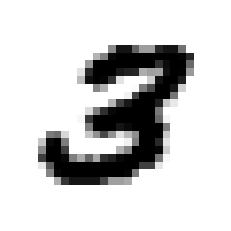

In [8]:
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [9]:
some_label

'3'

In [10]:
# Cast labels from string to int
y = y.astype(np.uint8)

### Split into train/test sets

MNIST dataset is already split into training data set: [:60000], [60000:]

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(60000, 10000, 60000, 10000)

## Training a Binary Classifier

Try to build a model to only detect 5-s, i.e. is the image '5' or not?

In [13]:
y_train_5 = (y_train == 5) # True for 5s, False for non-5s
y_test_5 = (y_test == 5)

# Model 1: SGDClassifier

In [14]:
from sklearn.linear_model import SGDClassifier

In [15]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
sgd_clf.predict([some_digit])

array([False])

### Cross-Validation

#### Custom kfold

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [18]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


#### using cross_val_score

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

## Dummy classifier that always predicts 'not 5'

In [20]:
from sklearn.base import BaseEstimator

In [21]:
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [22]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## Confusion Matrix

In [23]:
from sklearn.model_selection import cross_val_predict

In [24]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
confusion_matrix(y_train_5, y_train_pred)

array([[53115,  1464],
       [  916,  4505]])

In [27]:
# Pretend we reached perfection
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**Precision** - accuracy of the positive predictions

$precision= \dfrac{TP}{TP + FP}$

**Recall** - aka *sensitivity* or *true positive rate* - the ratio of positive instances that are correctly detected by the Never5Classifier

$recall = \dfrac{TP}{TP + FN}$

### Precision and Recall

In [28]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7547327860613168

In [29]:
recall_score(y_train_5, y_train_pred)

0.8310274857037447

### F1-score

F1-score is a harmonic mean of precision and recall. (harmonic mean gives much more weight to low values, so F1 will be high only if both recall and precision are high)

$F1 = \dfrac{2}{\dfrac{1}{precision}+\dfrac{1}{recall}} = 2 * \dfrac{precision * recall}{precision + recall} = \dfrac{TP}{TP+ \dfrac{FN + FP}{2}}$

In [30]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.791044776119403

## Using `decision_function()` instead of `predict()`

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-853.15875188])

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [33]:
y_some_digit_pred

array([False])

In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [35]:
from sklearn.metrics import precision_recall_curve

In [36]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.figure(figsize=(12,8))
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  plt.legend()
  plt.xlabel("Threshold")
  plt.show()



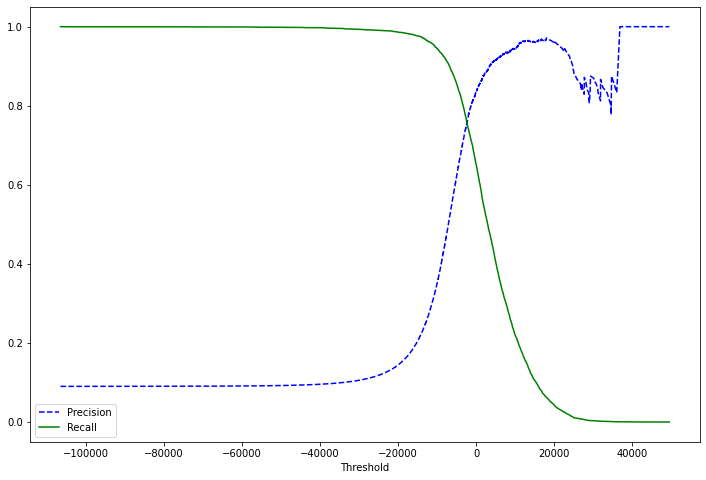

In [38]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [39]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [40]:
threshold_90_precision

3370.0194991439557

In [41]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [42]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [43]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## ROC Curve

In [44]:
from sklearn.metrics import roc_curve

In [45]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

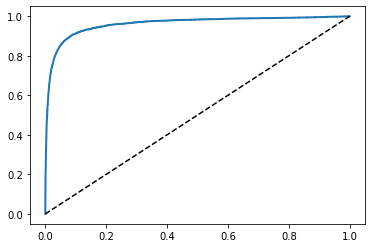

In [46]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plot_roc_curve(fpr, tpr)
plt.show()

## AUC: Area Under the Curve

A **perfect classifier** would have a ROC AUC equal to 1.

A **purely random classifier** would have a ROC AUC equal to 0.5. 

In [47]:
from sklearn.metrics import roc_auc_score

In [48]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

# Model 2: RandomForestClassifier

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [51]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

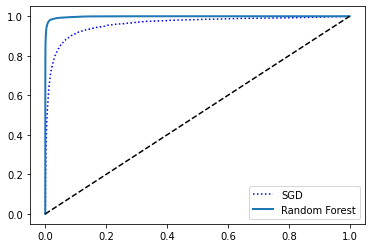

In [52]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [53]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### Convert probs into labels

In [54]:
forest_preds_rounded = np.round(y_scores_forest)
forest_preds_rounded

array([1., 0., 0., ..., 1., 0., 0.])

In [55]:
y_train_5[0] == forest_preds_rounded[0]

True

In [56]:
precision_score(y_train_5, forest_preds_rounded)

0.9905083315756169

In [57]:
recall_score(y_train_5, forest_preds_rounded)

0.8662608374838591

## Multiclass Classification

In [58]:
from sklearn.svm import SVC

In [59]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [60]:
svm_clf.predict([some_digit])

array([3], dtype=uint8)

Under the hood Sklearn trains 45 classifiers (one for each pair: since we have 10 digits, number of classifiers is $N(N-1)/2$,i.e 10*9/2=45)

In [61]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 4.74436965, -0.29693131,  8.29946046,  9.31554182,  1.70113615,
         6.25482878,  2.70823898,  0.70106125,  7.29776538,  3.76566173]])

In [62]:
np.argmax(some_digit_scores)

3

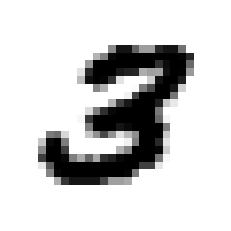

In [66]:
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()